# feature extraction for logistic ADNI models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading ADNI flair mask t1 dataset

In [3]:
# ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

In [4]:
# IDs = ADNI_ds.getIDs()

In [5]:
# len(IDs)

### Loading ADNI predictions

In [6]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [7]:
# model_name = "SSN_Ens_Mean"
model_name = "ssn_ens"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [01:05<00:00,  4.46it/s]


In [8]:
# model_name_for_pred = "SSN_Ens_Mean"
model_name = "ssn_ens"

output_maps_for_pred = output_maps_for_umaps
key_order_for_pred = key_order

In [9]:
key_order

['ent', 'pred', 'seg']

In [10]:
ID = list(output_maps_for_umaps.keys())[2]

In [11]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

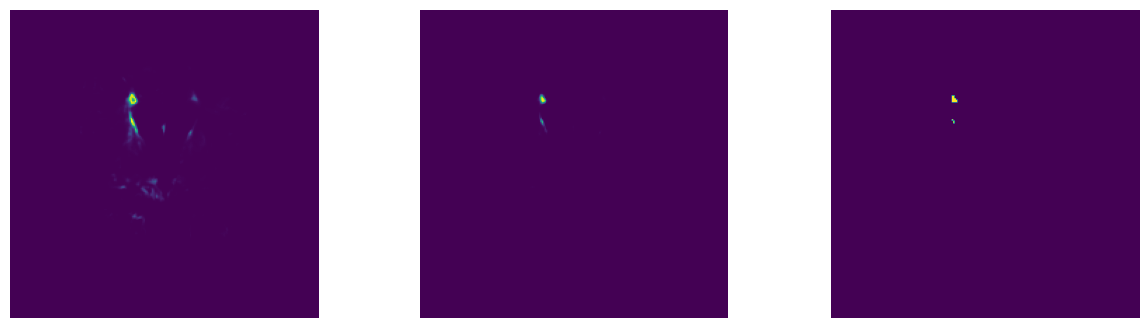

In [12]:
ent, pred, seg = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [13]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
# var_voxels = var[var > t/10]

<Axes: ylabel='Density'>

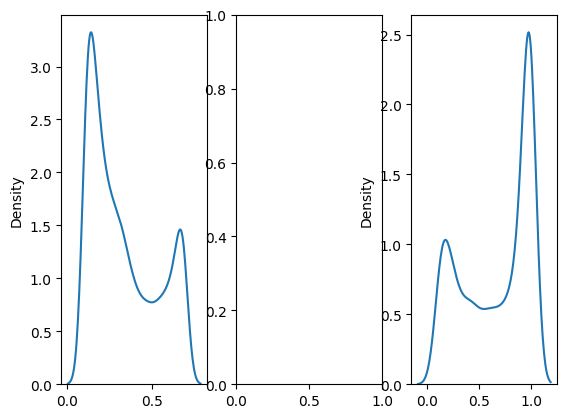

In [14]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,2)
# sns.kdeplot(var_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [15]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [16]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [17]:
histogram_distribution(ent_voxels, 20)

tensor([0.1581, 0.1194, 0.0913, 0.0749, 0.0586, 0.0590, 0.0524, 0.0520, 0.0406,
        0.0344, 0.0284, 0.0265, 0.0256, 0.0240, 0.0249, 0.0284, 0.0280, 0.0338,
        0.0398, 0.0000])

In [18]:
# counts, counts.sum()

<Axes: ylabel='Count'>

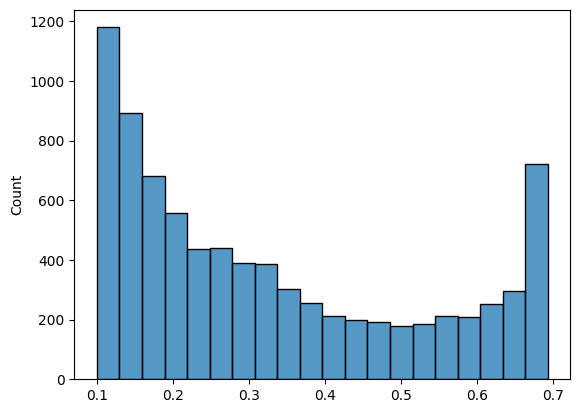

In [19]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [20]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [21]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [22]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((220, 220))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [23]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [24]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([58, 220, 220])

In [25]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.47it/s]


In [26]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([58, 220, 220]), tensor(33))

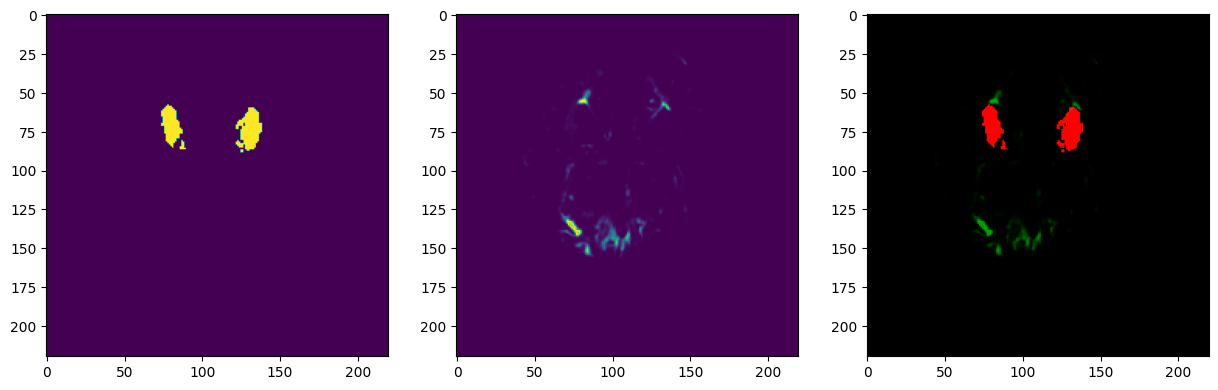

In [27]:
islice = 26
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[0].shape[1:], 3)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [28]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [29]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [30]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [31]:
import cc3d

In [32]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [33]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [34]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [35]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [36]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [37]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [38]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [39]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [40]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [41]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [42]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [43]:
# joint_counts.shape

In [44]:
# plt.imshow(joint_counts); plt.colorbar()

In [45]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [46]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [47]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [48]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [49]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [50]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [51]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [52]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            # elif input_type == "var":
            #     umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
            #     ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
            #     maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
    # break
        

  0%|                                                                                                                                                                 | 0/290 [00:00<?, ?it/s]

ADNI_002_S_0729_20110816


/tmp/ipykernel_2842642/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_2842642/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


159 152
124 112
112 96
142 84
181 81
272 108
59 43
55 27
50 18
50 10
46 0


  0%|▌                                                                                                                                                        | 1/290 [00:03<15:02,  3.12s/it]

47 0
ADNI_002_S_1155_20111222
243 239
125 120
68 63
56 49
56 46
64 45
37 30
22 14


  1%|█                                                                                                                                                        | 2/290 [00:04<10:44,  2.24s/it]

17 8
15 3
12 0
13 0
ADNI_002_S_1261_20110314
180 175
104 98
69 62
49 40
47 36
47 32
52 41
39 27
29 15
23 6
20 0


  1%|█▌                                                                                                                                                       | 3/290 [00:06<09:06,  1.90s/it]

14 0
ADNI_002_S_1280_20110504
168 160
91 82
85 75
103 77
131 75
171 79
50 32
38 16
38 14
33 4


  1%|██                                                                                                                                                       | 4/290 [00:08<09:22,  1.97s/it]

32 0
34 0
ADNI_002_S_2010_20101022
148 140
99 90
70 60
56 45
52 34
52 27
20 11


  2%|██▋                                                                                                                                                      | 5/290 [00:09<08:13,  1.73s/it]

19 10
19 9
16 6
11 0
13 0
ADNI_002_S_4213_20111205
175 167
101 91
66 55
63 48
68 48
83 51
48 36
42 29
30 17


  2%|███▏                                                                                                                                                     | 6/290 [00:11<07:55,  1.67s/it]

22 8
15 0
7 0
ADNI_002_S_4225_20111226
289 274
197 181
142 123
120 100
104 81
90 62
75 54
68 45
50 25
42 15
32 0


  2%|███▋                                                                                                                                                     | 7/290 [00:13<09:10,  1.95s/it]

29 0
ADNI_002_S_4229_20111221
344 330
232 212
206 184
170 145
162 133
167 120
116 90
69 39
67 34
46 11


  3%|████▏                                                                                                                                                    | 8/290 [00:16<11:06,  2.36s/it]

38 0
34 0
ADNI_002_S_4237_20110926
423 412
333 318
250 229
207 180
182 152
183 149
151 118
148 101
112 53
96 32


  3%|████▋                                                                                                                                                    | 9/290 [00:21<14:03,  3.00s/it]

96 0
73 0
ADNI_002_S_4262_20111005
308 286
266 233
236 194
205 156
210 151
233 143
150 97
128 66
118 50
92 17


  3%|█████▏                                                                                                                                                  | 10/290 [00:25<15:34,  3.34s/it]

85 0
81 0
ADNI_002_S_4270_20111011
172 165
116 107
76 63
63 46
77 49
125 61
51 37
44 28
31 15
32 10


  4%|█████▊                                                                                                                                                  | 11/290 [00:27<13:20,  2.87s/it]

24 0
22 0
ADNI_002_S_4447_20120814
174 154
132 110
107 81
111 66
129 70
148 75
60 35
45 17
42 10
43 7


  4%|██████▎                                                                                                                                                 | 12/290 [00:29<12:26,  2.69s/it]

46 0
47 0
ADNI_002_S_4473_20120823
442 432
309 296
194 179
151 132
125 104
124 96
98 78
67 43
65 36


  4%|██████▊                                                                                                                                                 | 13/290 [00:32<13:20,  2.89s/it]

52 20
40 0
33 0
ADNI_002_S_4521_20120904
265 256
175 164
108 97
88 75
79 60
87 59
47 35
33 20
35 15


  5%|███████▎                                                                                                                                                | 14/290 [00:34<12:11,  2.65s/it]

32 9
29 0
21 0
ADNI_002_S_4654_20121023
221 206
126 108
93 72
99 73
90 54
102 56
60 38
49 25
37 9
36 6


  5%|███████▊                                                                                                                                                | 15/290 [00:37<11:17,  2.46s/it]

32 0
24 0
ADNI_006_S_4150_20111107
161 154
100 93
51 44
52 40
50 35
56 36
34 25
21 11


  6%|████████▍                                                                                                                                               | 16/290 [00:38<09:44,  2.13s/it]

17 6
21 9
15 0
11 0
ADNI_006_S_4153_20111104
173 171
102 98
73 69
63 58
61 50
75 52
35 28
48 36
34 20
25 4
26 0


  6%|████████▉                                                                                                                                               | 17/290 [00:40<09:02,  1.99s/it]

28 0
ADNI_006_S_4192_20111215
295 284
222 202
187 164
144 119
137 111
128 93
92 64
68 38
59 22
50 8
51 0


  6%|█████████▍                                                                                                                                              | 18/290 [00:43<10:22,  2.29s/it]

44 0
ADNI_006_S_4357_20111128
137 134
83 79
73 62
70 47
75 45
94 46
42 31
37 25
39 23


  7%|█████████▉                                                                                                                                              | 19/290 [00:44<09:24,  2.08s/it]

34 11
30 0
18 0
ADNI_006_S_4363_20111116
142 137
65 60
51 43
37 27
45 29
54 34
34 24
30 19


  7%|██████████▍                                                                                                                                             | 20/290 [00:45<08:15,  1.84s/it]

25 12
21 6
19 0
20 0
ADNI_006_S_4485_20120824
220 199
165 141
134 103
150 78
232 106
320 123
71 42
60 27
58 20
54 12
53 0


  7%|███████████                                                                                                                                             | 21/290 [00:48<09:56,  2.22s/it]

52 0
ADNI_006_S_4679_20120601
194 182
129 112
95 75
115 72
143 72
179 78
67 46
47 22
43 13
41 7


  8%|███████████▌                                                                                                                                            | 22/290 [00:51<10:02,  2.25s/it]

38 0
31 0
ADNI_006_S_4713_20121128
183 175
111 100
75 63
75 58
80 47
90 45
39 27
38 24
24 7
29 9
24 0


  8%|████████████                                                                                                                                            | 23/290 [00:53<09:17,  2.09s/it]

21 0
ADNI_006_S_4960_20121009
240 228
167 154
133 118
103 87
105 87
127 103
103 86
84 65
59 36
48 20
35 0


  8%|████████████▌                                                                                                                                           | 24/290 [00:55<09:51,  2.23s/it]

32 0
ADNI_009_S_2208_20101201
140 133
84 76
53 43
64 46
68 45
76 41
36 28
25 17
23 15
17 9


  9%|█████████████                                                                                                                                           | 25/290 [00:56<08:43,  1.98s/it]

14 0
10 0
ADNI_009_S_4324_20111101
147 142
84 76
59 49
57 36
67 37
89 38
28 16
25 12
25 11


  9%|█████████████▋                                                                                                                                          | 26/290 [00:58<08:01,  1.82s/it]

26 8
19 0
12 0
ADNI_009_S_4359_20111205
130 124
67 61
46 38
38 23
53 29
62 27
23 15
16 6
25 10
29 8


  9%|██████████████▏                                                                                                                                         | 27/290 [00:59<07:18,  1.67s/it]

32 0
38 0
ADNI_009_S_4388_20111213
114 110
48 42
44 33
60 34
75 34
106 39
26 16
25 14


 10%|██████████████▋                                                                                                                                         | 28/290 [01:01<06:50,  1.57s/it]

19 6
20 1
19 0
10 0
ADNI_009_S_4543_20120912
76 71
51 44
61 49
78 52
103 52
126 56
42 33
32 20
30 13
31 11
24 0


 10%|███████████████▏                                                                                                                                        | 29/290 [01:02<06:43,  1.55s/it]

19 0
ADNI_009_S_4612_20121011
190 174
162 138
155 122
150 107
164 105
221 108
84 43
75 28
73 19
83 14
83 0


 10%|███████████████▋                                                                                                                                        | 30/290 [01:05<08:36,  1.99s/it]

71 0
ADNI_009_S_4741_20121015
243 229
163 146
134 113
115 91
116 84
134 78
93 68
73 44
53 21


 11%|████████████████▏                                                                                                                                       | 31/290 [01:08<09:15,  2.15s/it]

43 8
38 0
37 0
ADNI_010_S_4345_20120920
216 209
166 158
89 79
82 63
88 54
113 61
38 24
29 15


 11%|████████████████▊                                                                                                                                       | 32/290 [01:10<08:59,  2.09s/it]

28 12
24 8
22 0
20 0
ADNI_011_S_0021_20101008
180 176
108 101
74 67
66 52
61 42
63 36
36 29
31 24


 11%|█████████████████▎                                                                                                                                      | 33/290 [01:11<08:12,  1.92s/it]

23 13
15 4
12 0
12 0
ADNI_011_S_0023_20121227
158 150
96 86
79 67
83 55
91 52
103 54
57 43
40 26
33 18
25 8


 12%|█████████████████▊                                                                                                                                      | 34/290 [01:13<07:57,  1.87s/it]

21 0
18 0
ADNI_011_S_2274_20110818
269 266
130 125
100 91
102 77
106 67
148 77
63 49
50 35
43 24
36 12


 12%|██████████████████▎                                                                                                                                     | 35/290 [01:15<08:29,  2.00s/it]

37 0
36 0
ADNI_011_S_4075_20111214
126 122
73 67
52 45
44 32
54 37
75 38
29 21
28 18
20 7
17 1


 12%|██████████████████▊                                                                                                                                     | 36/290 [01:16<07:33,  1.79s/it]

20 0
17 0
ADNI_011_S_4105_20111005
140 134
89 81
66 54
78 50
95 53
124 61
40 30
35 23


 13%|███████████████████▍                                                                                                                                    | 37/290 [01:18<07:21,  1.74s/it]

27 14
22 6
19 0
14 0
ADNI_011_S_4120_20111010
127 121
74 66
55 42
66 40
84 45
122 48
32 22
24 12


 13%|███████████████████▉                                                                                                                                    | 38/290 [01:20<07:02,  1.68s/it]

23 9
21 3
22 0
26 0
ADNI_011_S_4222_20111207
157 148
105 96
60 49
62 34
87 40
128 44
36 22
28 12


 13%|████████████████████▍                                                                                                                                   | 39/290 [01:21<07:00,  1.67s/it]

21 5
19 2
23 0
25 0
ADNI_011_S_4235_20111219
213 205
143 132
90 79
83 59
97 59
115 53
56 42
38 21
37 16
30 2


 14%|████████████████████▉                                                                                                                                   | 40/290 [01:23<07:26,  1.78s/it]

40 0
34 0
ADNI_011_S_4278_20111013
167 163
101 97
77 71
80 67
86 65
84 47
44 36
33 22
29 16
28 12
29 0


 14%|█████████████████████▍                                                                                                                                  | 41/290 [01:25<07:17,  1.76s/it]

24 0
ADNI_011_S_4547_20120912
191 179
137 121
95 77
88 62
92 51
128 61
65 46
41 20
50 25


 14%|██████████████████████                                                                                                                                  | 42/290 [01:27<07:41,  1.86s/it]

53 21
35 0
28 0
ADNI_012_S_4012_20111107
155 150
92 86
63 56
57 42
41 26
41 24
27 20
19 10
14 5
15 3
16 0


 15%|██████████████████████▌                                                                                                                                 | 43/290 [01:28<06:57,  1.69s/it]

17 0
ADNI_012_S_4094_20111006
214 208
123 116
99 92
77 69
76 63
67 49
40 33
26 19


 15%|███████████████████████                                                                                                                                 | 44/290 [01:30<06:53,  1.68s/it]

18 11
14 6
8 0
4 0
ADNI_012_S_4128_20111101
275 258
196 177
169 150
127 106
112 85
128 84
93 70
66 42
52 26


 16%|███████████████████████▌                                                                                                                                | 45/290 [01:33<08:04,  1.98s/it]

43 14
37 0
31 0
ADNI_012_S_4188_20111213
212 205
120 111
91 78
93 73
101 68
133 71
37 26
33 19


 16%|████████████████████████                                                                                                                                | 46/290 [01:35<07:59,  1.96s/it]

31 15
25 9
20 0
17 0
ADNI_012_S_4545_20120924
158 140
116 97
106 84
115 82
125 87
136 84
85 61
54 27
38 11
38 9


 16%|████████████████████████▋                                                                                                                               | 47/290 [01:37<08:11,  2.02s/it]

30 0
29 0
ADNI_012_S_4643_20120627
173 164
83 74
66 55
77 56
86 57
104 58
46 35
27 16


 17%|█████████████████████████▏                                                                                                                              | 48/290 [01:38<07:36,  1.89s/it]

21 9
16 3
13 0
11 0
ADNI_013_S_1186_20110223
182 176
114 107
90 80
106 79
127 77
198 85
55 39
46 28
39 20
30 8


 17%|█████████████████████████▋                                                                                                                              | 49/290 [01:41<07:54,  1.97s/it]

25 0
23 0
ADNI_013_S_4268_20111101
176 171
105 100
76 70
61 51
54 44
47 36
41 31
36 25


 17%|██████████████████████████▏                                                                                                                             | 50/290 [01:42<07:17,  1.82s/it]

20 9
21 7
16 0
15 0
ADNI_013_S_4395_20120815
137 122
101 83
101 75
142 90
189 100
295 135
80 53
68 39
62 28
51 13
45 0


 18%|██████████████████████████▋                                                                                                                             | 51/290 [01:45<08:16,  2.08s/it]

48 0
ADNI_013_S_4580_20121015
258 247
158 146
110 95
100 78
108 83
112 79
70 51
50 28
47 22


 18%|███████████████████████████▎                                                                                                                            | 52/290 [01:47<08:30,  2.14s/it]

38 12
32 0
26 0
ADNI_013_S_4595_20121024
308 302
239 231
142 131
111 98
93 79
91 68
64 49
56 35
38 15
37 10


 18%|███████████████████████████▊                                                                                                                            | 53/290 [01:49<08:54,  2.26s/it]

33 0
24 0
ADNI_013_S_4616_20121025
410 402
323 312
261 249
222 197
217 175
249 160
103 90
65 49
42 24
31 11
25 0


 19%|████████████████████████████▎                                                                                                                           | 54/290 [01:53<10:42,  2.72s/it]

19 0
ADNI_014_S_2308_20110908
260 254
172 166
122 115
79 72
78 69
68 56
36 29
24 16
22 12
16 3


 19%|████████████████████████████▊                                                                                                                           | 55/290 [01:55<09:42,  2.48s/it]

14 0
12 0
ADNI_014_S_4039_20111208
196 189
133 125
84 76
43 35
35 26
35 24
34 25
18 9
18 8
18 4


 19%|█████████████████████████████▎                                                                                                                          | 56/290 [01:57<08:26,  2.16s/it]

14 0
12 0
ADNI_014_S_4058_20111222
132 124
80 68
69 55
53 34
65 35
79 30
34 18
29 11
22 4


 20%|█████████████████████████████▉                                                                                                                          | 57/290 [01:58<07:33,  1.95s/it]

27 5
24 0
24 0
ADNI_014_S_4079_20111215
144 141
79 75
72 66
54 39
76 41
90 38
26 21
17 11
24 15
25 6


 20%|██████████████████████████████▍                                                                                                                         | 58/290 [02:00<07:00,  1.81s/it]

26 0
33 0
ADNI_014_S_4263_20111006
319 299
227 204
188 162
157 128
153 123
129 94
91 62
61 32
46 17
36 6


 20%|██████████████████████████████▉                                                                                                                         | 59/290 [02:03<08:16,  2.15s/it]

32 0
28 0
ADNI_014_S_4328_20111107
197 191
129 123
91 85
54 48
45 39
43 36


 21%|███████████████████████████████▍                                                                                                                        | 60/290 [02:04<07:23,  1.93s/it]

30 24
15 9
7 1
8 1
8 0
9 0
ADNI_014_S_4401_20111202
162 156
108 102
63 56
40 33
29 22
38 28
28 21
21 13
15 5
15 1


 21%|███████████████████████████████▉                                                                                                                        | 61/290 [02:05<06:36,  1.73s/it]

17 0
20 0
ADNI_014_S_4576_20120920
111 104
68 61
47 39
40 29
49 31
65 30
26 17
12 3
13 2
15 2
15 0


 21%|████████████████████████████████▍                                                                                                                       | 62/290 [02:06<05:54,  1.55s/it]

12 0
ADNI_018_S_2155_20101202
215 205
138 127
106 92
85 69
73 49
82 49
53 39
36 19
42 20


 22%|█████████████████████████████████                                                                                                                       | 63/290 [02:08<06:20,  1.67s/it]

40 16
31 0
31 0
ADNI_018_S_2180_20101209
171 167
108 103
73 68
54 49
51 46
47 40
44 39
26 21


 22%|█████████████████████████████████▌                                                                                                                      | 64/290 [02:10<05:58,  1.59s/it]

22 16
10 3
7 0
6 0
ADNI_018_S_4313_20111128
106 101
70 64
61 52
70 48
62 37
79 38
35 24
31 17
25 9


 22%|██████████████████████████████████                                                                                                                      | 65/290 [02:11<05:45,  1.54s/it]

31 10
29 0
21 0
ADNI_018_S_4349_20111115
204 183
135 108
124 94
122 70
164 86
221 96
85 54
73 37
73 35
64 20
60 0


 23%|██████████████████████████████████▌                                                                                                                     | 66/290 [02:14<07:07,  1.91s/it]

52 0
ADNI_018_S_4399_20111215
104 98
64 55
62 53
50 41
48 36
45 28
35 25
21 11
19 8
15 2
17 0


 23%|███████████████████████████████████                                                                                                                     | 67/290 [02:15<06:17,  1.69s/it]

14 0
ADNI_018_S_4400_20111220
204 189
149 132
101 84
83 65
72 52
61 40
55 37
39 19
38 15


 23%|███████████████████████████████████▋                                                                                                                    | 68/290 [02:17<06:28,  1.75s/it]

33 7
32 0
27 0
ADNI_018_S_4809_20121005
452 443
380 367
303 287
223 200
200 171
196 153
157 127
109 72
79 37
69 19
59 0


 24%|████████████████████████████████████▏                                                                                                                   | 69/290 [02:21<09:24,  2.56s/it]

59 0
ADNI_018_S_4868_20121114
265 260
172 165
87 79
62 52
67 54
79 49
26 18
29 15
22 7
27 4
27 0


 24%|████████████████████████████████████▋                                                                                                                   | 70/290 [02:23<08:39,  2.36s/it]

22 0
ADNI_018_S_4889_20121114
373 352
284 258
225 194
228 186
242 192
233 174
126 88
99 59
74 31
64 20


 24%|█████████████████████████████████████▏                                                                                                                  | 71/290 [02:27<10:25,  2.86s/it]

48 0
45 0
ADNI_019_S_4252_20111214
286 277
216 205
164 151
147 116
173 114
187 94
70 57
41 28
26 12
24 8


 25%|█████████████████████████████████████▋                                                                                                                  | 72/290 [02:30<10:16,  2.83s/it]

19 0
15 0
ADNI_019_S_4285_20111013
217 205
158 140
127 104
136 86
202 102
279 114
88 56
72 35
70 27
58 13
53 0


 25%|██████████████████████████████████████▎                                                                                                                 | 73/290 [02:33<10:24,  2.88s/it]

51 0
ADNI_019_S_4293_20111020
218 213
121 113
104 92
85 67
84 64
94 64
69 54
64 49
35 17
31 10
26 0


 26%|██████████████████████████████████████▊                                                                                                                 | 74/290 [02:35<09:25,  2.62s/it]

21 0
ADNI_019_S_4367_20111130
224 215
141 132
78 67
73 55
78 51
95 56
43 31
37 23
32 15
34 8
42 0


 26%|███████████████████████████████████████▎                                                                                                                | 75/290 [02:37<08:39,  2.42s/it]

37 0
ADNI_019_S_4477_20120807
208 199
175 163
142 129
115 99
103 86
111 90
99 78
87 59
75 35
75 29


 26%|███████████████████████████████████████▊                                                                                                                | 76/290 [02:40<08:53,  2.49s/it]

62 0
58 0
ADNI_019_S_4680_20121029
177 166
100 86
78 57
75 47
76 43
88 48
34 20
23 9


 27%|████████████████████████████████████████▎                                                                                                               | 77/290 [02:41<07:52,  2.22s/it]

19 5
19 4
15 0
12 0
ADNI_019_S_4835_20121008
244 239
136 129
99 89
60 49
60 46
52 32
47 33
36 18


 27%|████████████████████████████████████████▉                                                                                                               | 78/290 [02:43<07:22,  2.09s/it]

33 15
29 9
23 0
18 0
ADNI_022_S_2167_20101102
272 269
178 173
107 101
89 67
116 68
154 72
44 37
44 34
37 22
26 7


 27%|█████████████████████████████████████████▍                                                                                                              | 79/290 [02:45<07:41,  2.19s/it]

23 0
21 0
ADNI_022_S_2263_20110823
193 185
113 102
87 70
111 60
147 62
204 64
44 28
36 18
33 12
35 7
41 0


 28%|█████████████████████████████████████████▉                                                                                                              | 80/290 [02:48<07:47,  2.23s/it]

37 0
ADNI_022_S_4173_20110913
125 121
54 49
46 38
48 33
68 40
84 35
40 32
29 17
30 15


 28%|██████████████████████████████████████████▍                                                                                                             | 81/290 [02:49<06:49,  1.96s/it]

24 9
17 0
18 0
ADNI_022_S_4291_20111122
197 191
138 131
74 67
67 42
82 33
100 31
20 12
19 9
18 7


 28%|██████████████████████████████████████████▉                                                                                                             | 82/290 [02:51<06:28,  1.87s/it]

16 2
16 0
15 0
ADNI_022_S_4320_20111109
186 174
122 110
64 50
78 46
78 38
95 34
43 29
28 14


 29%|███████████████████████████████████████████▌                                                                                                            | 83/290 [02:52<06:16,  1.82s/it]

31 17
23 9
16 0
16 0
ADNI_022_S_4444_20120822
114 109
63 55
37 27
56 28
78 34
113 48
26 14
22 9


 29%|████████████████████████████████████████████                                                                                                            | 84/290 [02:54<05:46,  1.68s/it]

22 8
23 6
20 0
20 0
ADNI_023_S_2068_20101201
182 174
104 95
60 49
60 39
74 41
100 41
43 31
31 19


 29%|████████████████████████████████████████████▌                                                                                                           | 85/290 [02:55<05:42,  1.67s/it]

27 11
23 5
23 0
22 0
ADNI_023_S_4020_20110803
226 210
122 105
76 56
74 48
87 54
108 55
59 35
56 26
62 26
54 12
48 0


 30%|█████████████████████████████████████████████                                                                                                           | 86/290 [02:58<06:07,  1.80s/it]

44 0
ADNI_023_S_4035_20110728
234 226
169 158
131 112
129 92
155 89
265 114
65 42
60 30
57 24
54 12
49 0


 30%|█████████████████████████████████████████████▌                                                                                                          | 87/290 [03:00<07:10,  2.12s/it]

55 0
ADNI_023_S_4115_20111129
130 125
71 65
69 61
67 47
75 42
95 48
50 39
49 35
44 23
35 8
34 0


 30%|██████████████████████████████████████████████                                                                                                          | 88/290 [03:02<06:39,  1.98s/it]

29 0
ADNI_023_S_4164_20110830
188 183
117 109
86 77
67 57
62 47
72 45
56 44
42 27
31 14
32 12


 31%|██████████████████████████████████████████████▋                                                                                                         | 89/290 [03:04<06:24,  1.91s/it]

23 0
22 0
ADNI_023_S_4243_20111109
281 271
230 215
151 131
144 105
178 101
297 115
60 42
51 29
39 14
41 11


 31%|███████████████████████████████████████████████▏                                                                                                        | 90/290 [03:07<07:33,  2.27s/it]

36 0
38 0
ADNI_023_S_4448_20120816
112 105
79 70
57 46
48 30
53 29
52 27
33 22
21 10
21 9
22 7
17 0


 31%|███████████████████████████████████████████████▋                                                                                                        | 91/290 [03:08<06:30,  1.96s/it]

15 0
ADNI_023_S_4501_20121101
251 244
182 171
144 128
131 113
128 102
145 91
74 59
53 35
44 22
38 13


 32%|████████████████████████████████████████████████▏                                                                                                       | 92/290 [03:11<07:06,  2.15s/it]

32 0
30 0
ADNI_023_S_4502_20121025
111 105
85 78
69 62
52 39
55 33
75 40
27 16
37 19
44 23


 32%|████████████████████████████████████████████████▋                                                                                                       | 93/290 [03:12<06:22,  1.94s/it]

38 10
34 0
28 0
ADNI_023_S_4796_20121120
232 222
151 141
113 100
107 72
148 73
239 81
33 22
26 12


 32%|█████████████████████████████████████████████████▎                                                                                                      | 94/290 [03:15<06:43,  2.06s/it]

23 8
21 3
23 0
22 0
ADNI_024_S_4084_20110916
172 167
103 97
56 48
54 39
57 37
70 42
36 27
29 17
27 14
28 7
28 0


 33%|█████████████████████████████████████████████████▊                                                                                                      | 95/290 [03:16<06:10,  1.90s/it]

28 0
ADNI_024_S_4158_20111111
219 211
147 138
92 82
80 69
61 50
58 44
45 32
30 13
30 13


 33%|██████████████████████████████████████████████████▎                                                                                                     | 96/290 [03:18<06:03,  1.87s/it]

34 14
22 0
24 0
ADNI_024_S_4169_20111128
205 197
114 105
78 68
65 47
77 46
96 52
45 34
33 21


 33%|██████████████████████████████████████████████████▊                                                                                                     | 97/290 [03:20<05:53,  1.83s/it]

25 12
22 8
21 0
25 0
ADNI_024_S_4392_20120709
147 142
90 85
102 72
218 92
341 109
555 163
51 41
30 19
26 12
28 9
24 0


 34%|███████████████████████████████████████████████████▎                                                                                                    | 98/290 [03:23<07:10,  2.24s/it]

18 0
ADNI_024_S_4674_20121119
165 136
117 86
97 57
122 66
165 83
198 89
73 31
72 29
56 13
50 4
47 0


 34%|███████████████████████████████████████████████████▉                                                                                                    | 99/290 [03:25<07:21,  2.31s/it]

47 0
ADNI_031_S_2018_20100923
246 234
182 165
154 136
132 103
159 106
195 94
83 63
66 39
61 31


 34%|████████████████████████████████████████████████████                                                                                                   | 100/290 [03:28<07:47,  2.46s/it]

46 14
36 0
28 0
ADNI_031_S_2022_20101012
162 154
89 80
56 47
40 30
45 29
45 25
36 24
24 12


 35%|████████████████████████████████████████████████████▌                                                                                                  | 101/290 [03:29<06:41,  2.12s/it]

28 13
22 3
24 0
18 0
ADNI_031_S_2233_20101215
166 154
121 104
92 71
94 65
110 64
117 58
68 44
57 30
54 22


 35%|█████████████████████████████████████████████████████                                                                                                  | 102/290 [03:32<06:35,  2.11s/it]

44 7
42 0
31 0
ADNI_031_S_4021_20111020
232 224
159 150
111 101
86 74
84 71
74 59
45 32
32 18
28 13


 36%|█████████████████████████████████████████████████████▋                                                                                                 | 103/290 [03:33<06:22,  2.05s/it]

23 7
16 0
18 0
ADNI_031_S_4032_20111205
115 108
81 72
53 44
62 48
62 45
70 48
49 38
38 23
27 11


 36%|██████████████████████████████████████████████████████▏                                                                                                | 104/290 [03:35<05:44,  1.85s/it]

25 8
18 0
15 0
ADNI_031_S_4149_20111103
226 218
170 157
113 97
107 73
132 81
191 86
50 32
43 22
35 13
30 6


 36%|██████████████████████████████████████████████████████▋                                                                                                | 105/290 [03:37<06:11,  2.01s/it]

26 0
25 0
ADNI_031_S_4194_20111201
133 130
64 61
50 47
30 27
36 32
36 29
25 20
26 19


 37%|███████████████████████████████████████████████████████▏                                                                                               | 106/290 [03:38<05:21,  1.75s/it]

24 13
23 9
16 0
12 0
ADNI_031_S_4203_20111205
244 241
195 191
155 150
119 113
103 97
100 94
64 55
50 40
26 14


 37%|███████████████████████████████████████████████████████▋                                                                                               | 107/290 [03:41<05:54,  1.94s/it]

27 10
20 0
19 0
ADNI_031_S_4218_20111208
340 329
234 221
184 169
151 133
138 111
132 95
82 64
55 34
45 18


 37%|████████████████████████████████████████████████████████▏                                                                                              | 108/290 [03:44<06:48,  2.24s/it]

42 11
39 0
30 0
ADNI_031_S_4476_20120817
210 202
112 103
78 65
77 46
106 41
171 52
34 18
30 13
30 8
27 3
25 0


 38%|████████████████████████████████████████████████████████▊                                                                                              | 109/290 [03:46<06:31,  2.16s/it]

22 0
ADNI_031_S_4496_20120820
131 125
80 73
61 54
58 51
59 49
63 44
36 29
25 16
22 9
18 4


 38%|█████████████████████████████████████████████████████████▎                                                                                             | 110/290 [03:47<05:44,  1.91s/it]

15 0
16 0
ADNI_031_S_4947_20120928
139 134
108 103
62 55
44 35
44 32
51 36
40 33
25 17


 38%|█████████████████████████████████████████████████████████▊                                                                                             | 111/290 [03:48<05:10,  1.73s/it]

20 11
17 7
11 0
14 0
ADNI_032_S_2119_20101215
129 121
96 81
98 77
120 66
169 82
236 90
58 36
50 25
53 22
52 15
45 0


 39%|██████████████████████████████████████████████████████████▎                                                                                            | 112/290 [03:51<05:42,  1.92s/it]

39 0
ADNI_032_S_4277_20111019
124 116
84 75
49 39
59 40
70 44
84 45
45 31
42 25
35 16


 39%|██████████████████████████████████████████████████████████▊                                                                                            | 113/290 [03:52<05:20,  1.81s/it]

30 3
39 0
30 0
ADNI_032_S_4386_20111213
130 123
70 60
63 53
64 44
73 42
92 46
43 29
30 15
30 13


 39%|███████████████████████████████████████████████████████████▎                                                                                           | 114/290 [03:54<05:01,  1.72s/it]

23 5
26 0
26 0
ADNI_032_S_4429_20111222
140 129
86 70
79 54
95 49
136 57
193 63
49 23
50 22
50 18


 40%|███████████████████████████████████████████████████████████▉                                                                                           | 115/290 [03:56<05:20,  1.83s/it]

47 12
46 0
38 0
ADNI_033_S_4176_20130904
159 145
97 81
91 73
95 65
97 54
135 61
57 35
42 16
39 12
34 5


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 116/290 [03:58<05:29,  1.90s/it]

34 0
31 0
ADNI_033_S_4177_20130911
354 345
262 246
228 201
221 179
237 174
319 197
147 117
117 83
99 57
74 30


 40%|████████████████████████████████████████████████████████████▉                                                                                          | 117/290 [04:02<07:26,  2.58s/it]

57 0
38 0
ADNI_035_S_4082_20111214
359 352
229 220
126 112
91 71
94 66
115 66
40 26
28 13
23 8
27 5
27 0


 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 118/290 [04:05<07:18,  2.55s/it]

28 0
ADNI_035_S_4114_20130314
169 161
130 121
90 80
71 54
74 52
86 51
53 40
28 15


 41%|█████████████████████████████████████████████████████████████▉                                                                                         | 119/290 [04:06<06:38,  2.33s/it]

22 8
21 6
16 0
17 0
ADNI_035_S_4464_20120803
170 164
80 74
56 50
30 22
28 19
28 14
17 10
14 6
15 5
11 1


 41%|██████████████████████████████████████████████████████████████▍                                                                                        | 120/290 [04:07<05:34,  1.97s/it]

10 0
9 0
ADNI_035_S_4582_20120924
173 164
78 69
44 35
29 15
34 12
56 22
17 6
21 9
20 6


 42%|███████████████████████████████████████████████████████████████                                                                                        | 121/290 [04:09<04:56,  1.75s/it]

17 2
19 0
21 0
ADNI_035_S_4784_20121025
156 131
126 94
118 78
167 81
203 79
310 104
72 32
68 23
55 10
55 4
55 0


 42%|███████████████████████████████████████████████████████████████▌                                                                                       | 122/290 [04:12<05:52,  2.10s/it]

51 0
ADNI_036_S_4389_20111207
171 166
84 76
47 38
43 32
43 32
57 41
34 24
31 19
26 12


 42%|████████████████████████████████████████████████████████████████                                                                                       | 123/290 [04:13<05:14,  1.89s/it]

25 8
19 0
16 0
ADNI_036_S_4430_20111223
167 159
97 89
64 56
82 53
127 59
154 62
28 19
23 14


 43%|████████████████████████████████████████████████████████████████▌                                                                                      | 124/290 [04:15<05:07,  1.85s/it]

17 5
19 5
18 0
14 0
ADNI_036_S_4491_20120809
185 181
119 114
68 63
37 28
44 27
46 20
15 9
13 7
12 4
15 7


 43%|█████████████████████████████████████████████████████████████████                                                                                      | 125/290 [04:16<04:38,  1.69s/it]

10 0
6 0
ADNI_036_S_4538_20121101
117 110
68 60
45 36
32 21
37 21
44 19
29 18
20 7
17 4


 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 126/290 [04:17<04:08,  1.51s/it]

14 1
17 0
12 0
ADNI_036_S_4562_20121009
173 161
103 87
70 52
72 41
101 49
149 64
41 23
38 17
31 6
34 4
35 0


 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 127/290 [04:19<04:26,  1.63s/it]

33 0
ADNI_036_S_4714_20121204
76 67
49 36
43 28
44 28
48 30
51 25
34 19
20 4


 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 128/290 [04:20<03:58,  1.47s/it]

21 4
21 4
18 0
15 0
ADNI_036_S_4715_20121127
116 108
59 50
44 31
46 26
50 23
57 21
32 19
26 11
29 13


 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 129/290 [04:21<03:45,  1.40s/it]

26 9
20 0
14 0
ADNI_036_S_4736_20121206
344 317
273 238
219 172
227 163
250 155
325 172
148 86
148 75
126 44
112 24


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 130/290 [04:26<06:16,  2.35s/it]

101 0
86 0
ADNI_036_S_4878_20121019
81 77
47 43
36 31
36 29
42 33
36 24


 45%|████████████████████████████████████████████████████████████████████▏                                                                                  | 131/290 [04:27<05:06,  1.93s/it]

29 24
16 11
14 9
6 1
5 0
3 0
ADNI_037_S_0501_20130422
340 331
242 232
196 185
138 122
136 112
128 91
74 61
46 31
34 18
26 6


 46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 132/290 [04:30<05:45,  2.19s/it]

21 0
16 0
ADNI_037_S_0566_20150729
315 310
272 266
219 213
162 152
131 118
117 102
80 68
70 56
37 22
29 10


 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 133/290 [04:33<06:20,  2.42s/it]

23 0
29 0
ADNI_037_S_4015_20150408
318 312
225 216
135 125
124 98
130 86
166 81
53 40
37 21
34 17
31 12


 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 134/290 [04:35<06:29,  2.50s/it]

27 0
24 0
ADNI_037_S_4028_20150604
127 117
68 57
65 45
103 52
147 68
189 85
33 17
26 9
25 6
28 5
26 0


 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 135/290 [04:37<05:56,  2.30s/it]

22 0
ADNI_037_S_4030_20150527
190 185
95 86
83 64
136 66
193 70
277 80
37 26
32 20
32 15
29 9
28 0


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 136/290 [04:40<05:58,  2.33s/it]

22 0
ADNI_037_S_4071_20151111
269 263
215 206
181 170
152 133
136 108
166 113
82 65
86 63
64 32
59 19
67 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 137/290 [04:43<06:32,  2.56s/it]

79 0
ADNI_037_S_4146_20150902
183 171
103 87
81 62
80 48
91 48
111 53
54 34
40 18
37 14
37 6


 48%|███████████████████████████████████████████████████████████████████████▊                                                                               | 138/290 [04:45<05:59,  2.36s/it]

38 0
34 0
ADNI_037_S_4214_20151016
186 180
97 89
63 54
44 31
54 30
73 31
33 20
25 10
30 10


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 139/290 [04:46<05:19,  2.12s/it]

32 8
30 0
23 0
ADNI_037_S_4302_20131211
223 211
131 116
83 68
69 47
85 47
107 51
41 24
32 15
24 6
24 4
26 0


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 140/290 [04:48<05:06,  2.04s/it]

23 0
ADNI_037_S_4308_20140409
181 175
85 78
49 40
45 35
40 28
49 33
40 28
40 24
35 16
31 9
36 0


 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 141/290 [04:50<04:39,  1.88s/it]

31 0
ADNI_037_S_4381_20140321
252 248
125 120
68 63
41 36
30 24
29 22
18 12
16 9
17 10
10 3
8 0


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
 49%|█████████████████████████████████████████████████████████████████████████▉                                                       

5 0
ADNI_037_S_4410_20140115
112 105
78 68
56 44
59 43
58 31
71 35
36 22
23 9
22 7
20 3


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 143/290 [04:52<03:56,  1.61s/it]

21 0
19 0
ADNI_037_S_4706_20140512
182 176
109 102
91 83
55 45
55 39
56 36
39 29
28 18


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 144/290 [04:54<03:51,  1.59s/it]

29 17
24 12
17 0
13 0
ADNI_041_S_4004_20140428
156 147
92 83
67 58
52 35
67 38
81 29
31 22
24 14
28 14


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 145/290 [04:55<03:45,  1.55s/it]

22 6
16 0
12 0
ADNI_041_S_4014_20111202
311 304
196 186
126 114
86 71
94 73
103 67
79 61
57 36
49 25


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 146/290 [04:58<04:22,  1.83s/it]

45 18
34 0
32 0
ADNI_041_S_4037_20111205
167 159
96 85
71 60
58 47
56 43
58 39
50 38
48 33
39 23
31 11
28 0


 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 147/290 [04:59<04:12,  1.77s/it]

26 0
ADNI_041_S_4041_20111213
107 102
52 45
35 27
23 13
21 10
26 11
20 12
17 9
20 10
16 5


 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 148/290 [05:00<03:35,  1.52s/it]

12 0
8 0
ADNI_041_S_4051_20110923
328 309
210 185
147 119
150 100
168 99
216 99
82 49
69 31
59 17
56 10
52 0


 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 149/290 [05:04<04:45,  2.02s/it]

48 0
ADNI_041_S_4060_20111212
152 130
100 74
99 60
142 58
198 76
274 93
63 31
54 18
54 17
46 7
42 0


 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 150/290 [05:06<05:08,  2.21s/it]

42 0
ADNI_041_S_4138_20111021
104 96
85 72
89 64
119 62
163 71
295 97
49 29
42 21
41 17
36 9


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 151/290 [05:08<05:10,  2.23s/it]

33 0
33 0
ADNI_041_S_4143_20111122
134 123
80 67
76 54
90 49
124 53
152 55
37 18
36 16
39 13
35 9
29 0


 52%|███████████████████████████████████████████████████████████████████████████████▏                                                                       | 152/290 [05:10<04:51,  2.11s/it]

25 0
ADNI_041_S_4200_20111219
156 128
134 103
108 72
126 65
149 64
177 72
77 40
80 40
62 20
56 10
49 0


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 153/290 [05:13<05:04,  2.22s/it]

41 0
ADNI_041_S_4271_20111007
115 111
65 61
50 45
36 31
38 33
33 25
30 25
20 15
14 9


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 154/290 [05:14<04:15,  1.88s/it]

12 4
13 0
14 0
ADNI_041_S_4427_20111219
224 217
135 127
81 71
78 60
92 64
98 57
52 39
46 26
36 16
33 9


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 155/290 [05:16<04:17,  1.91s/it]

28 0
28 0
ADNI_041_S_4510_20120910
137 131
72 66
48 40
53 38
52 32
62 33
34 27
21 13
18 10
15 4


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 156/290 [05:17<03:50,  1.72s/it]

15 0
14 0
ADNI_041_S_4513_20120905
232 228
142 136
93 87
67 60
51 44
48 40
46 39
26 19


 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 157/290 [05:19<03:46,  1.70s/it]

22 15
10 1
10 0
8 0
ADNI_041_S_4720_20121109
167 160
81 70
66 48
95 38
152 47
250 80
39 27
26 12


 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 158/290 [05:21<03:58,  1.81s/it]

22 7
22 5
23 0
22 0
ADNI_041_S_4874_20121105
109 102
58 51
51 43
46 34
46 29
62 35
25 18
17 10
14 6
11 3
10 0


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 159/290 [05:22<03:29,  1.60s/it]

11 0
ADNI_041_S_4876_20121106
177 169
109 99
86 63
141 65
224 79
374 109
40 24
40 21
41 20
39 13
37 0


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 160/290 [05:25<04:12,  1.94s/it]

34 0
ADNI_041_S_4877_20121212
168 157
101 86
84 63
97 57
123 65
145 60
52 30
41 17
32 7
30 3


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 161/290 [05:27<04:11,  1.95s/it]

29 0
29 0
ADNI_041_S_4974_20121015
208 205
104 98
92 74
119 75
173 98
248 110
52 41
41 29
40 25
31 11


 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 162/290 [05:29<04:26,  2.08s/it]

27 0
26 0
ADNI_041_S_4989_20121019
135 130
63 53
52 42
56 41
59 39
78 38
40 28
28 14
25 11


 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 163/290 [05:30<03:57,  1.87s/it]

22 5
24 0
20 0
ADNI_053_S_4578_20121003
221 204
142 122
109 84
106 60
135 67
196 80
70 42
59 23
53 15
50 7
48 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 164/290 [05:33<04:20,  2.07s/it]

44 0
ADNI_053_S_4661_20120528
172 166
111 104
71 61
50 39
53 36
60 36
40 29
32 17


 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 165/290 [05:34<03:57,  1.90s/it]

23 8
25 9
20 0
17 0
ADNI_053_S_4813_20120928
185 177
117 106
74 60
69 47
91 60
94 56
48 32
41 21
38 16
33 10


 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 166/290 [05:36<03:51,  1.87s/it]

26 0
18 0
ADNI_067_S_2195_20101119
201 195
96 90
44 37
37 29
29 19
34 19
26 18
15 7
13 5


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 167/290 [05:37<03:26,  1.68s/it]

12 1
13 0
12 0
ADNI_067_S_2301_20110830
222 216
128 122
78 72
57 50
53 45
53 41
44 36
28 20


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 168/290 [05:39<03:21,  1.65s/it]

18 9
15 4
12 0
11 0
ADNI_067_S_2304_20110914
221 215
112 106
82 71
51 36
68 38
85 36
23 16
16 9
12 5


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 169/290 [05:41<03:15,  1.62s/it]

8 1
9 0
8 0
ADNI_067_S_4054_20111215
157 152
89 81
60 45
102 60
133 58
204 69
38 27
29 15


 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 170/290 [05:42<03:24,  1.71s/it]

23 5
24 4
22 0
23 0
ADNI_067_S_4072_20111012
147 143
85 79
54 45
60 48
71 56
78 52
47 36
43 29
29 14


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 171/290 [05:44<03:17,  1.66s/it]

25 6
26 0
17 0
ADNI_067_S_4184_20111219
243 236
137 130
103 96
85 75
78 62
74 52
59 51
35 27
24 16


 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 172/290 [05:46<03:22,  1.72s/it]

16 5
15 0
13 0
ADNI_067_S_4212_20111219
485 475
253 241
165 152
121 105
111 95
106 87
74 57
55 37
39 19
32 11


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 173/290 [05:49<04:04,  2.09s/it]

25 0
17 0
ADNI_067_S_4310_20111027
191 184
106 98
80 72
54 42
59 39
58 32
48 40
22 13


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 174/290 [05:50<03:42,  1.92s/it]

24 12
18 5
15 0
15 0
ADNI_067_S_4767_20121210
231 222
185 174
144 132
109 95
92 76
79 62
54 41
36 22
31 15
24 7
18 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 175/290 [05:52<03:47,  1.98s/it]

17 0
ADNI_067_S_4782_20121026
232 227
184 175
157 147
123 109
121 104
119 87
63 53
38 27
28 16
24 11
17 0


 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 176/290 [05:55<03:56,  2.08s/it]

13 0
ADNI_068_S_4061_20111219
113 107
68 60
46 37
41 29
43 26
62 30
27 15
34 17
24 6


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 177/290 [05:56<03:27,  1.84s/it]

29 5
31 0
28 0
ADNI_068_S_4217_20111214
179 173
125 117
84 75
62 47
78 46
99 44
36 25
36 22


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 178/290 [05:58<03:21,  1.80s/it]

29 15
22 5
22 0
19 0
ADNI_072_S_2116_20101026
ADNI_072_S_4007_20111101
118 115
75 71
64 57
48 40
47 34
62 37
39 29
33 22
31 15


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 180/290 [05:59<02:23,  1.30s/it]

30 5
38 0
37 0
ADNI_072_S_4057_20111212
ADNI_072_S_4063_20111219
ADNI_072_S_4103_20110720
125 118
83 71
64 51
48 35
52 32
47 26
35 22
26 11
27 9


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 183/290 [06:01<01:35,  1.12it/s]

29 8
25 0
26 0
ADNI_072_S_4769_20121017
183 158
129 102
101 69
102 59
105 54
117 52
54 20
56 20
51 14


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 184/290 [06:03<02:00,  1.13s/it]

50 9
44 0
39 0
ADNI_073_S_0311_20110901
258 248
163 148
131 108
147 104
142 80
183 87
58 37
56 32
47 22


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 185/290 [06:05<02:32,  1.45s/it]

38 9
34 0
32 0
ADNI_073_S_0746_20120213
207 193
133 119
102 87
71 52
73 48
84 48
42 27
30 14
23 7
16 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 186/290 [06:07<02:40,  1.54s/it]

19 0
13 0
ADNI_073_S_2153_20101105
289 278
194 179
135 120
88 72
74 57
68 45
52 36
44 27
32 14


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 187/290 [06:09<02:55,  1.71s/it]

27 6
29 0
22 0
ADNI_073_S_2191_20110708
123 120
56 52
45 40
48 34
59 31
92 36
26 19
20 11
17 8
15 3


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 188/290 [06:11<02:42,  1.59s/it]

14 0
15 0
ADNI_073_S_2225_20110808
189 181
93 85
63 53
60 45
64 38
79 42
36 26
30 19
26 14


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 189/290 [06:12<02:39,  1.58s/it]

19 6
20 0
20 0
ADNI_073_S_2264_20110721
179 163
112 91
91 64
128 80
154 80
225 98
60 33
65 32
53 15
46 5
44 0
41 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 190/290 [06:15<03:03,  1.83s/it]

ADNI_073_S_4216_20111206
325 320
180 175
109 103
68 61
58 51
49 42
49 42
29 19
22 11
20 8


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 191/290 [06:17<03:04,  1.87s/it]

12 0
10 0
ADNI_073_S_4300_20111012
303 293
194 184
140 128
116 98
138 98
162 81
61 45
54 34
40 17
35 9


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 192/290 [06:19<03:24,  2.09s/it]

27 0
24 0
ADNI_073_S_4311_20111017
131 127
79 75
45 37
62 46
66 40
91 40
44 36
26 15
25 13


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 193/290 [06:21<03:06,  1.92s/it]

30 9
29 0
28 0
ADNI_073_S_4312_20111017
132 127
95 88
63 56
40 33
37 29
36 24
29 21
29 17


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 194/290 [06:22<02:45,  1.73s/it]

25 11
26 9
17 0
12 0
ADNI_073_S_4360_20111104
119 115
66 62
59 54
56 40
75 46
109 50
37 29
32 23


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 195/290 [06:24<02:36,  1.65s/it]

29 19
21 9
18 0
16 0
ADNI_073_S_4382_20111115
108 104
64 59
48 43
33 24
39 24
49 23
26 18
18 9
15 6


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 196/290 [06:25<02:19,  1.48s/it]

14 4
12 0
13 0
ADNI_073_S_4393_20111122
279 274
145 140
121 116
75 68
74 66
67 58
54 47
43 33
32 19


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 197/290 [06:27<02:32,  1.64s/it]

28 11
22 0
9 0
ADNI_073_S_4552_20120524
257 241
199 181
179 160
148 122
131 99
128 89
98 74
78 51
61 31


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 198/290 [06:30<03:02,  1.99s/it]

52 15
49 0
39 0
ADNI_073_S_4559_20121012
353 337
288 266
256 229
181 145
169 122
173 112
116 83
90 50
78 35
61 14


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 199/290 [06:33<03:42,  2.44s/it]

54 0
41 0
ADNI_073_S_4614_20120919
158 155
93 88
44 39
37 29
37 28
39 28
30 22
23 15
20 11


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 200/290 [06:34<03:06,  2.07s/it]

13 3
12 0
12 0
ADNI_073_S_4739_20121114
128 120
95 86
60 50
47 33
63 40
77 41
38 28
23 12
19 7
18 1


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 201/290 [06:36<02:44,  1.85s/it]

20 0
20 0
ADNI_073_S_4777_20121212
226 221
140 130
105 86
96 65
116 68
149 64
37 25
31 18
32 16
31 11
26 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 202/290 [06:38<02:49,  1.92s/it]

23 0
ADNI_073_S_4795_20120606
142 138
93 88
58 53
49 42
43 36
43 36
36 29
32 22
28 15
29 13
17 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 203/290 [06:39<02:31,  1.74s/it]

14 0
ADNI_073_S_5023_20130403
189 186
108 104
57 53
46 41
46 41
50 36
34 29
22 15


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 204/290 [06:40<02:20,  1.63s/it]

20 10
22 8
18 0
13 0
ADNI_082_S_2121_20101012
190 185
82 75
70 63
58 51
48 37
50 35
54 45
28 18
19 8
21 7


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 205/290 [06:42<02:13,  1.57s/it]

18 0
21 0
ADNI_082_S_4090_20110921
123 118
64 57
52 41
42 21
52 23
80 38
29 19
19 6
24 9


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 206/290 [06:43<02:05,  1.49s/it]

33 12
29 0
28 0
ADNI_082_S_4208_20111207
302 291
191 178
153 140
121 103
111 91
111 73
70 55
45 29
32 15
24 6


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 207/290 [06:45<02:27,  1.77s/it]

21 0
24 0
ADNI_082_S_4244_20111019
270 264
194 187
123 115
106 87
124 74
180 88
47 38
44 33
27 16
25 11
17 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 208/290 [06:48<02:40,  1.95s/it]

19 0
ADNI_082_S_4339_20111109
123 118
99 92
57 50
47 38
49 35
57 35
36 27
44 31
34 21
31 11
30 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 209/290 [06:49<02:25,  1.80s/it]

25 0
ADNI_100_S_4469_20121023
208 205
131 128
82 78
41 36
34 27
30 21
20 13
24 15
20 11
16 4


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 210/290 [06:51<02:14,  1.68s/it]

15 0
10 0
ADNI_100_S_4512_20121106
175 168
104 96
83 71
90 59
113 59
169 76
55 37
44 23
43 20
40 13


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 211/290 [06:53<02:21,  1.79s/it]

34 0
29 0
ADNI_100_S_4556_20121126
355 345
214 203
159 148
107 96
79 67
78 61
46 35
29 17


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 212/290 [06:55<02:29,  1.92s/it]

22 10
19 6
14 0
9 0
ADNI_114_S_4404_20120802
139 134
71 65
42 36
36 29
36 29
33 19
28 22
18 9
22 11


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 213/290 [06:56<02:09,  1.68s/it]

21 5
24 0
17 0
ADNI_116_S_4043_20111209
274 268
194 185
172 160
133 116
130 109
131 97
71 56
45 29
37 19
31 9


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 214/290 [06:59<02:27,  1.93s/it]

27 0
23 0
ADNI_116_S_4092_20110921
118 110
72 56
68 49
99 57
125 58
204 78
33 20
31 13
30 12
27 7
27 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 215/290 [07:00<02:23,  1.91s/it]

27 0
ADNI_116_S_4167_20111109
170 165
132 126
94 88
62 56
51 45
47 41
42 36
26 19


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 216/290 [07:02<02:11,  1.78s/it]

17 9
15 6
16 0
13 0
ADNI_116_S_4175_20111114
107 105
64 61
40 37
33 28
34 29
36 30
29 24
26 20
14 6


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 217/290 [07:03<01:52,  1.55s/it]

11 3
10 0
11 0
ADNI_116_S_4195_20111209
115 110
77 71
48 42
30 24
25 19
22 15
18 12
13 7
15 9
13 7
6 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 218/290 [07:04<01:38,  1.37s/it]

4 0
ADNI_116_S_4199_20111123
110 107
58 54
31 26
25 20
28 23
33 20
22 17
19 14
19 10


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 219/290 [07:05<01:28,  1.25s/it]

15 4
13 0
11 0
ADNI_116_S_4453_20120809
266 263
185 178
113 106
81 69
81 67
71 52
52 43
43 25
37 15


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 220/290 [07:07<01:44,  1.50s/it]

37 11
35 0
26 0
ADNI_116_S_4483_20120821
140 135
89 83
67 59
49 32
58 36
79 43
28 18
26 15
24 13
18 5


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 221/290 [07:08<01:40,  1.46s/it]

14 0
9 0
ADNI_116_S_4625_20121019
229 223
122 115
95 87
75 64
68 55
56 39
42 33
34 23


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 222/290 [07:10<01:44,  1.53s/it]

28 15
21 6
21 0
20 0
ADNI_116_S_4635_20121015
211 197
152 134
125 102
141 92
168 94
223 98
63 39
65 33
57 19
57 11
52 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 223/290 [07:13<02:05,  1.87s/it]

52 0
ADNI_116_S_4898_20121107
145 138
78 70
57 46
47 35
51 34
56 34
30 20
28 16
31 17
23 8
17 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 224/290 [07:14<01:53,  1.72s/it]

19 0
ADNI_123_S_2363_20110422
164 163
114 111
74 68
82 65
102 75
111 62
45 36
37 23
37 19
27 8
27 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 225/290 [07:16<01:52,  1.73s/it]

26 0
ADNI_123_S_4127_20111114
143 136
81 74
71 64
58 45
44 28
43 22
24 15
18 8
19 9
17 4
16 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 226/290 [07:17<01:41,  1.58s/it]

13 0
ADNI_123_S_4170_20111209
217 212
129 122
106 96
84 68
80 62
74 52
56 43
32 17
27 11
25 7
22 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 227/290 [07:19<01:44,  1.65s/it]

22 0
ADNI_123_S_4526_20120814
320 307
160 144
126 104
128 95
143 96
153 89
91 71
47 26
37 14
34 10


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 228/290 [07:21<01:59,  1.93s/it]

31 0
27 0
ADNI_123_S_4780_20121220
175 168
94 87
60 52
54 43
63 45
74 43
39 30
22 11
21 6
17 1


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 229/290 [07:23<01:48,  1.78s/it]

19 0
15 0
ADNI_130_S_2373_20111101
137 134
102 99
71 67
57 50
51 44
47 36
47 41
25 17
24 15
18 8


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 230/290 [07:24<01:38,  1.64s/it]

11 0
10 0
ADNI_130_S_4250_20111005
274 267
155 146
89 79
60 47
57 38
61 37
50 37
38 18
32 11
29 7


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 231/290 [07:26<01:40,  1.70s/it]

25 0
22 0
ADNI_130_S_4294_20111121
232 221
181 170
132 120
115 100
108 87
126 85
72 59
47 28
54 27


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 232/290 [07:28<01:50,  1.91s/it]

50 18
38 0
31 0
ADNI_130_S_4343_20111109
258 246
165 151
124 107
111 84
121 76
147 74
57 34
59 27
54 19


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 233/290 [07:31<01:58,  2.09s/it]

48 9
42 0
39 0
ADNI_130_S_4405_20120416
223 214
129 118
121 107
105 89
84 64
85 54
67 55
46 32
26 12
20 6
18 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 234/290 [07:33<01:54,  2.05s/it]

17 0
ADNI_130_S_4415_20120517
200 187
143 127
99 82
94 58
122 61
185 71
63 42
49 24
37 11
29 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 235/290 [07:35<01:55,  2.10s/it]

33 0
32 0
ADNI_130_S_4417_20120727
212 204
144 136
87 76
72 56
79 56
101 54
46 35
36 22
40 19
34 10
35 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 236/290 [07:37<01:52,  2.09s/it]

33 0
ADNI_130_S_4468_20120813
168 164
103 96
101 92
88 78
74 61
73 58
64 54
42 31
24 12


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 237/290 [07:39<01:43,  1.96s/it]

14 1
17 0
15 0
ADNI_130_S_4641_20121010
297 286
199 177
137 101
142 86
187 99
252 112
79 48
65 29
51 13
52 7
51 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 238/290 [07:42<01:59,  2.29s/it]

44 0
ADNI_135_S_4281_20111014
131 114
93 71
76 49
122 69
180 77
294 113
53 27
55 24
51 17
50 9
48 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 239/290 [07:44<02:00,  2.36s/it]

42 0
ADNI_135_S_4309_20111026
99 93
67 60
52 42
71 44
74 40
117 55
35 24
38 26


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 240/290 [07:46<01:44,  2.09s/it]

30 16
28 12
19 0
21 0
ADNI_135_S_4356_20111110
122 118
61 57
49 44
40 34
41 31
45 26
25 17
30 19
31 18
28 11
25 0
24 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 241/290 [07:47<01:29,  1.82s/it]

ADNI_135_S_4406_20111207
206 200
121 115
73 67
41 34
34 27
33 26
35 28
25 17
15 7
11 1
11 0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 242/290 [07:48<01:20,  1.69s/it]

8 0
ADNI_135_S_4446_20120809
150 122
94 62
87 53
103 48
114 49
145 57
59 23
51 15
49 11


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 243/290 [07:50<01:23,  1.78s/it]

45 5
41 0
39 0
ADNI_135_S_4489_20120802
117 110
47 39
51 40
58 34
67 27
124 46
34 22
31 16
28 12
23 3
30 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 244/290 [07:52<01:16,  1.67s/it]

32 0
ADNI_135_S_4566_20120919
160 154
87 81
62 54
62 45
74 44
121 55
39 30
34 21
26 12
20 4
21 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 245/290 [07:53<01:14,  1.66s/it]

22 0
ADNI_135_S_4598_20121016
190 185
94 89
67 62
39 33
34 28
34 27
27 21
15 8
14 6


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 246/290 [07:55<01:07,  1.53s/it]

13 5
9 0
8 0
ADNI_135_S_4657_20121029
223 212
152 137
119 95
100 71
101 62
116 61
69 48
50 27
46 19


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 247/290 [07:57<01:14,  1.74s/it]

44 10
39 0
32 0
ADNI_135_S_4676_20121106
172 164
111 102
85 71
84 54
90 47
125 61
48 31
48 30
44 24
42 14


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 248/290 [07:59<01:14,  1.78s/it]

33 0
31 0
ADNI_135_S_4689_20121116
151 146
81 72
55 45
39 24
47 29
59 30
32 18
42 26
33 16


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 249/290 [08:00<01:08,  1.66s/it]

25 8
21 0
20 0
ADNI_135_S_4722_20121205
156 142
102 87
68 49
60 34
79 30
107 39
35 18
34 16


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 250/290 [08:02<01:05,  1.63s/it]

28 7
29 6
25 0
22 0
ADNI_135_S_4723_20121205
94 85
50 40
56 38
69 34
89 36
126 40
34 20
30 14
30 14
30 11
26 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 251/290 [08:03<01:01,  1.57s/it]

26 0
ADNI_137_S_4211_20111213
88 81
59 51
55 45
45 30
60 32
68 30
22 14
22 14
14 6


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 252/290 [08:04<00:54,  1.44s/it]

10 2
11 0
9 0
ADNI_137_S_4258_20111011
265 259
150 143
83 75
69 60
53 44
52 41
41 31
39 27


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 253/290 [08:06<00:56,  1.53s/it]

33 21
27 13
15 0
16 0
ADNI_137_S_4299_20111102
321 310
210 197
158 142
133 116
119 100
113 89
100 80
78 54
60 34


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 254/290 [08:09<01:08,  1.89s/it]

47 18
34 0
24 0
ADNI_137_S_4331_20111116
256 249
184 173
171 155
133 116
145 122
140 111
92 71
95 65
87 49
69 23
60 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 255/290 [08:12<01:17,  2.21s/it]

61 0
ADNI_137_S_4351_20111202
163 156
100 91
62 52
37 27
40 24
39 23
39 29
20 8


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 256/290 [08:13<01:06,  1.94s/it]

19 6
23 7
20 0
17 0
ADNI_137_S_4466_20120827
150 143
95 88
54 47
41 33
36 25
42 22
24 16
20 10
24 10


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 257/290 [08:14<00:57,  1.74s/it]

22 7
17 0
12 0
ADNI_137_S_4482_20120914
70 65
52 45
44 37
40 28
45 29
51 29
32 25
15 8
10 3


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 258/290 [08:15<00:48,  1.51s/it]

9 2
8 0
10 0
ADNI_137_S_4520_20120926
112 105
74 66
52 44
41 31
36 23
46 23
25 15
23 12
24 10


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 259/290 [08:16<00:43,  1.40s/it]

21 6
18 0
19 0
ADNI_137_S_4536_20120910
121 115
62 52
44 26
74 29
135 44
227 59
16 6
17 4
20 7


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 260/290 [08:18<00:44,  1.49s/it]

23 5
21 0
19 0
ADNI_137_S_4587_20121018
136 130
105 98
74 67
44 36
45 33
45 29
34 27
22 13
14 3


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 261/290 [08:19<00:41,  1.42s/it]

14 2
15 0
11 0
ADNI_137_S_4596_20121008
177 171
93 86
49 41
45 30
42 25
56 30
25 16
23 13
18 5
18 4
23 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 262/290 [08:21<00:39,  1.40s/it]

18 0
ADNI_137_S_4623_20121112
165 152
105 91
81 66
67 50
66 47
63 32
46 30
45 25
37 11
40 10


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 263/290 [08:22<00:39,  1.47s/it]

34 0
25 0
ADNI_137_S_4631_20121213
223 220
173 166
156 149
131 124
115 108
117 110
76 69


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 264/290 [08:25<00:43,  1.69s/it]

35 28
20 13
16 8
9 0
4 0
ADNI_137_S_4632_20121217
144 139
91 85
54 48
68 60
60 51
47 37
47 32
44 27
45 24
41 15
38 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 265/290 [08:26<00:41,  1.65s/it]

42 0
ADNI_137_S_4672_20121016
130 124
73 66
48 41
34 25
36 27
29 19
26 18
17 9
12 4


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 266/290 [08:27<00:35,  1.48s/it]

15 4
15 0
14 0
ADNI_137_S_4678_20121126
125 116
90 81
67 53
74 46
80 36
121 46
38 20
33 15
31 10
27 6
25 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 267/290 [08:29<00:34,  1.51s/it]

21 0
ADNI_137_S_4815_20121019
100 87
87 65
79 50
127 65
176 82
275 109
44 19
44 17
48 20


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 268/290 [08:31<00:37,  1.73s/it]

40 9
37 0
38 0
ADNI_137_S_4816_20121031
184 159
128 99
110 71
185 96
268 100
432 133
60 28
57 20
56 14
53 9
46 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 269/290 [08:34<00:45,  2.15s/it]

48 0
ADNI_141_S_4160_20111205
362 354
223 215
166 157
89 79
89 78
86 74
65 54
42 31
28 17


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 270/290 [08:37<00:44,  2.22s/it]

19 6
18 0
12 0
ADNI_141_S_4232_20110924
259 254
152 145
77 69
45 35
50 34
68 36
29 18
30 16


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 271/290 [08:38<00:39,  2.06s/it]

29 14
23 6
20 0
19 0
ADNI_153_S_2109_20101005
ADNI_153_S_2148_20101026
115 111
54 49
43 37
56 30
110 53
179 73
38 30
31 22
27 12
23 4
28 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 273/290 [08:40<00:25,  1.49s/it]

23 0
ADNI_153_S_4077_20110920
403 392
256 242
159 143
96 80
95 77
96 69
63 47
50 29
40 15
35 7
38 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 274/290 [08:43<00:28,  1.78s/it]

32 0
ADNI_153_S_4133_20111102
194 186
101 93
51 35
82 36
98 33
161 44
20 9
20 8
15 3


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 275/290 [08:44<00:26,  1.79s/it]

15 2
19 0
15 0
ADNI_153_S_4151_20111107
181 175
93 84
59 48
63 45
76 46
89 41
37 24
31 18
29 12


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 276/290 [08:46<00:24,  1.73s/it]

21 2
25 0
20 0
ADNI_153_S_4159_20111108
136 132
72 66
50 42
30 22
37 26
46 27
24 16
30 18


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 277/290 [08:47<00:20,  1.57s/it]

22 8
17 2
18 0
17 0
ADNI_153_S_4172_20111031
191 186
96 89
68 58
54 40
61 36
75 38
33 22
34 21
34 19


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 278/290 [08:49<00:18,  1.56s/it]

26 9
20 0
17 0
ADNI_153_S_4372_20111130
137 134
70 66
43 38
26 20
33 25
32 23
23 17
24 15
23 12


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 279/290 [08:50<00:15,  1.42s/it]

18 7
13 0
10 0
ADNI_153_S_4621_20121030
339 323
253 234
204 183
156 133
148 122
132 100
77 54
52 27
39 14
38 7


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 280/290 [08:53<00:18,  1.85s/it]

32 0
23 0
ADNI_941_S_1195_20110315
156 150
96 89
57 49
59 43
67 40
85 39
35 27
30 22
18 10
15 5


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 281/290 [08:54<00:15,  1.74s/it]

12 0
10 0
ADNI_941_S_2060_20101206
161 155
98 89
96 71
159 70
239 89
442 135
51 37
33 18
34 14
39 7
41 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/290 [08:57<00:16,  2.06s/it]

38 0
ADNI_941_S_4036_20111006
250 242
115 106
72 63
49 39
42 30
38 26
24 15
14 5
14 4
11 0
12 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 283/290 [08:58<00:13,  1.86s/it]

10 0
ADNI_941_S_4100_20111003
147 136
104 88
100 69
218 83
377 118
622 170
47 29
40 20
37 15
39 12
35 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 284/290 [09:02<00:13,  2.32s/it]

41 0
ADNI_941_S_4187_20111128
188 184
105 98
61 54
57 45
60 46
58 38
41 32
43 31


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 285/290 [09:03<00:10,  2.08s/it]

34 19
33 11
28 0
17 0
ADNI_941_S_4255_20111202
151 146
79 71
49 41
61 44
75 39
112 47
41 32
23 13
25 11
36 15
28 0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 286/290 [09:05<00:07,  1.92s/it]

21 0
ADNI_941_S_4292_20111205
103 97
54 48
41 35
41 34
42 30
42 23
26 19
29 21


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 287/290 [09:06<00:05,  1.67s/it]

22 13
16 6
12 0
12 0
ADNI_941_S_4365_20111122
383 376
258 249
179 168
123 110
100 80
119 77
47 35
40 24
40 21
32 11


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 288/290 [09:09<00:04,  2.00s/it]

30 0
30 0
ADNI_941_S_4376_20110601
212 194
150 129
112 87
111 70
141 78
200 84
56 32
45 18
43 14
39 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 289/290 [09:11<00:02,  2.12s/it]

32 0
35 0
ADNI_941_S_4764_20120820
104 96
64 55
53 44
59 32
117 40
187 49
21 13
23 14
21 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [09:13<00:00,  1.91s/it]

23 8
24 0
22 0


In [53]:
data['ADNI_002_S_0729_20110816'].keys()

dict_keys(['ent', 'pred'])

In [54]:
example_data = data['ADNI_002_S_0729_20110816']

In [55]:
example_data['ent']['0.45'].keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [56]:
example_data['ent']['0.45']['dist_value_joint'].view(-1).tolist()

[0.2732732594013214,
 0.08708708733320236,
 0.0030030030757188797,
 0.0,
 0.0,
 0.19519519805908203,
 0.03903903812170029,
 0.0030030030757188797,
 0.0,
 0.0,
 0.16516517102718353,
 0.036036036908626556,
 0.0030030030757188797,
 0.0,
 0.0,
 0.12912912666797638,
 0.012012012302875519,
 0.0,
 0.0,
 0.0,
 0.051051050424575806,
 0.0030030030757188797,
 0.0,
 0.0,
 0.0]

In [57]:
row_data = example_data['ent']['0.45']

In [58]:
row_data.keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [59]:
import pandas as pd

In [60]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:01<00:00, 239.80it/s]


In [61]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/{model_name}_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.55it/s]


In [62]:
# save the per individual connected component statistic
# np_df = {}
# for key in pd_other_data_dfs.keys():
#     np_df[key] = np.array(pd_other_data_dfs[key])
# np.save("umap_data_spreadsheets/ADNI/connected_component_data.npy", np_df)

### building the clinscore dataset

In [63]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


### Loading ADNI spreadsheets

In [66]:
adni_dir = "/home/s2208943/ipdis/data/ADNI_data/"
spreadsheet_dir = adni_dir
# dataset with clinical variables (e.g age, and a bunch of other factors)
variables_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [67]:
list(variables_df.iloc[0].items())

[('Unnamed: 0', 'Patient ID'),
 ('GENERAL INFO ', 'DX.bl'),
 ('Unnamed: 2', 'AGE'),
 ('Unnamed: 3', 'PTGENDER'),
 ('Unnamed: 4', 'PTEDUCAT'),
 ('Unnamed: 5', 'PTRACCAT'),
 ('Unnamed: 6', 'APOE4'),
 ('BASELINE BRAIN MEASUREMENTS (% of ICV)', 'Ventricles_bl %'),
 ('Unnamed: 8', 'Hippocampus_bl %'),
 ('Unnamed: 9', 'WholeBrain_bl %'),
 ('Unnamed: 10', 'Entorhinal_bl %'),
 ('Unnamed: 11', 'Fusiform_bl %'),
 ('Unnamed: 12', 'MidTemp_bl %'),
 ('IMAGE ANALYSIS FINDINGS ', 'BMB Y1 Count'),
 ('Unnamed: 14', 'BMB Y2 Count'),
 ('Unnamed: 15', 'BMB Y3 Count'),
 ('MEDICAL HISTORY', 'VSBPDIA'),
 ('Unnamed: 17', 'VSBPSYS'),
 ('Unnamed: 18', 'VSPULSE'),
 ('Unnamed: 19', 'BMI'),
 ('Unnamed: 20', 'CV RISK FACTORS'),
 ('Unnamed: 21', 'E-M RISK FACTORS')]

In [68]:
# dataset with fazekas ratings by Maria. I only have 290 of the 298 due to a few images missing matches, which is a shame
# but hopefully this is enough information. Nice.
ratings_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [69]:
def normalize_column(df, column_id):
    # normalizes a column (not inlcuding nan values)
    values = df[column_id].values.astype(np.float32)
    values = values[~np.isnan(values)]
    mean = values.mean()
    std = values.std()
    df[column_id] = (df[column_id].values - mean)/std

In [70]:
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    

In [71]:
def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

In [72]:
def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values.astype(np.float32)
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df

In [73]:
def prepare_ADNI_dfs(
    ratings_df, variables_df,
    selected_columns=[
        'Patient ID', 'AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
        'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %',
        'MidTemp_bl %', 'BMI', 'DX.bl', 'CV RISK FACTORS', 'APOE4',
        'WMH_PV', 'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS',
    ]):
    
    r_df = ratings_df.copy()
    v_df = variables_df.copy()

    # in the variables df, put all the column headings actually in the heading,
    variables_heading_map = {
        key:column_heading 
        for (column_heading, key) in v_df.iloc[0].items()
    }
    for key, column_heading in variables_heading_map.items():
        v_df[key] = v_df[column_heading].values
        v_df = v_df.drop(columns=[column_heading], inplace=False)
    
    
    # remove any * characters and ' ' from patient IDs
    r_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in r_df['Patient ID'].values]
    v_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in v_df['Patient ID'].values]
    
    # remove any rows that do not have a patient ID. patient ID can be detected due to having a '_S_' string in it.
    pid_locs_rdf = ['_S_' in pid for pid in r_df['Patient ID'].values]
    pid_locs_vdf = ['_S_' in pid for pid in v_df['Patient ID'].values]
    r_df = r_df.loc[pid_locs_rdf]
    v_df = v_df.loc[pid_locs_vdf]
    
    # join the two dataframes
    df = pd.merge(r_df, v_df, how='left')
    
    print(df.keys())
    
    # drop any column that isn't selected
    df = df[selected_columns]
    
    # normalize columns
    for norm_column in ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'PTEDUCAT', 'PTRACCAT']:
        if norm_column in selected_columns:
            normalize_column(df, norm_column)
            
    # one hot encoder columns
    for one_hot_col in ['DX.bl', 'CV RISK FACTORS', 'APOE4']:
        if one_hot_col in selected_columns:
            df = one_hot_encode(df, one_hot_col)
            
    # set values of zero to nan for brain measurement fields
    for no_zero_col in ['Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %']:
        df = convert_symbol_to_nan(df, no_zero_col, 0)
            
    # change PTGENDER column to 0,1 (as opposed to 1, 2)
    df['PTGENDER'] = df['PTGENDER'] - 1
    
    # in all selected columns, drop rows that contain a nan value
    for col in df.keys():
        if col not in ['Patient ID']:
            try:
                df = filter_rows_with_nans(df, col)
            except:
                print("failed on: ", col)
    
    return df

In [74]:
combined_df = prepare_ADNI_dfs(ratings_df, variables_df)

Index(['Patient ID', 'Image_year', 'PVS_BG', 'PVS_CS', 'Unnamed: 4',
       'Image_year.1', 'WMH_PV', 'WMH_Deep', 'Total', 'Obs', 'DX.bl', 'AGE',
       'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'APOE4', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMB Y1 Count', 'BMB Y2 Count',
       'BMB Y3 Count', 'VSBPDIA', 'VSBPSYS', 'VSPULSE', 'BMI',
       'CV RISK FACTORS', 'E-M RISK FACTORS'],
      dtype='object')


In [75]:
combined_df

,Patient ID,AGE,Ventricles_bl %,Hippocampus_bl %,WholeBrain_bl %,Entorhinal_bl %,Fusiform_bl %,MidTemp_bl %,BMI,WMH_PV,...,DX.bl_0,DX.bl_1,DX.bl_2,DX.bl_3,CV RISK FACTORS_0,CV RISK FACTORS_1,CV RISK FACTORS_2,APOE4_0,APOE4_1,APOE4_2
0,002_S_0729,-0.907124,-0.599118,0.20911,0.410522,-0.386959,0.803329,0.252266,-0.935346,2.0,...,False,False,True,False,False,True,False,False,True,False
1,002_S_1155,-1.913287,-1.640056,-2.9568,-3.247881,-2.848414,-3.151439,-3.17256,-0.778481,1.0,...,False,False,True,False,False,True,False,True,False,False
2,002_S_1261,-0.08014,0.09773,-0.15541,0.197169,-0.629183,0.0498,0.232463,-0.908899,1.0,...,True,False,False,False,False,False,True,True,False,False
3,002_S_1280,-0.135273,-0.49072,0.148831,0.182368,0.396004,0.125605,-0.024744,2.393686,3.0,...,True,False,False,False,False,False,True,False,True,False
4,002_S_2010,-1.210351,-0.724175,0.889532,0.357138,0.261112,0.243122,0.582234,3.287072,1.0,...,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,941_S_4255,0.099039,0.032813,-0.126676,0.208292,0.009422,0.287841,0.377825,0.013404,1.0,...,True,False,False,False,True,False,False,False,True,False
279,941_S_4292,-0.107707,-0.280526,0.599915,0.374701,0.714687,0.126096,0.437157,-0.017095,1.0,...,True,False,False,False,False,True,False,True,False,False
280,941_S_4365,1.1879,1.205062,-0.016664,0.10102,0.432068,0.203846,-0.216243,-0.803431,1.0,...,True,False,False,False,False,False,True,True,False,False
281,941_S_4376,0.664144,-1.640056,-2.9568,-3.247881,-2.848414,-3.151439,-3.17256,0.442142,2.0,...,True,False,False,False,False,True,False,True,False,False


In [76]:
combined_df['totatal_fazekas'] = (combined_df['WMH_Deep'].values + combined_df['WMH_PV'].values)

In [77]:
combined_df['totatal_fazekas'].values

array([4., 1., 2., 5., 2., 1., 3., 4., 5., 2., 2., 2., 1., 2., 1., 2., 4.,
       2., 1., 4., 2., 2., 2., 2., 2., 3., 1., 5., 4., 3., 2., 2., 2., 2.,
       2., 3., 2., 3., 3., 1., 2., 2., 2., 2., 4., 1., 6., 3., 3., 5., 1.,
       1., 3., 3., 2., 2., 1., 2., 1., 3., 2., 0., 4., 1., 5., 3., 2., 2.,
       4., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 2., 2.,
       4., 2., 2., 2., 5., 1., 2., 1., 5., 3., 4., 2., 2., 2., 2., 1., 0.,
       3., 0., 0., 1., 4., 1., 2., 4., 2., 2., 2., 4., 2., 2., 2., 1., 4.,
       2., 2., 2., 2., 1., 4., 0., 4., 2., 3., 6., 2., 2., 4., 2., 0., 2.,
       0., 2., 0., 0., 3., 4., 6., 2., 3., 0., 2., 2., 0., 3., 2., 4., 3.,
       3., 1., 3., 2., 2., 0., 0., 1., 2., 0., 1., 2., 1., 0., 2., 1., 2.,
       0., 1., 2., 0., 1., 2., 2., 2., 2., 1., 2., 4., 0., 2., 3., 2., 0.,
       1., 1., 1., 2., 2., 1., 1., 5., 0., 1., 2., 2., 2., 4., 1., 0., 4.,
       2., 2., 4., 0., 1., 0., 0., 1., 1., 1., 4., 2., 2., 2., 1., 2., 1.,
       1., 2., 3., 4., 0.

In [78]:
combined_df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/clinscore_data.csv")